In [1]:
# run on simulation data
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import os
import sys
import pickle as pkl
import ast
import pandas as pd
import random
import json 
import pickle
from tqdm import tqdm
from scipy.sparse import lil_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import math
import scanpy as sc
import anndata as ad
from scipy import stats
import squidpy as sq
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings

In [2]:
import RegChat

# Load data

In [3]:
path = '/Users/lihuazhang/Documents/projects/RegChat/RegChat_code/Dataset/Simulation/'
signaling_pathway = pd.read_csv(path + 'signaling_pathway.csv')
#gene_cell_pd = pd.read_csv(path + 'gene_cell_pd_80_1.csv',sep=',',index_col=0)
gene_cell_pd = pd.read_csv(path + 'gene_cell_pd_80_1.csv',sep=',',index_col=0)
coord = pd.read_csv(path + 'coordinates_df.csv',sep='\t')
cell_type = pd.read_csv(path + 'spot_CT1_CT3_label_str.txt',sep='\t')
cell_type.index = gene_cell_pd.columns

In [4]:
coord.index = gene_cell_pd.columns
spot_loc = coord

In [5]:
# build adata for RNA-seq
obs = pd.DataFrame({
    'cell_type': cell_type['Label']
}, index= gene_cell_pd.columns)
var = pd.DataFrame({
    'gene_name': gene_cell_pd.index
}, index=gene_cell_pd.index)

In [6]:
# Initialize AnnData
adata_rna = ad.AnnData(X=gene_cell_pd.to_numpy().T, obs=obs, var=var)
print(adata_rna)

AnnData object with n_obs × n_vars = 490 × 50
    obs: 'cell_type'
    var: 'gene_name'


In [7]:
# add ref to label
from RegChat import model
adata_rna = model.label_to_int(adata_rna)

In [8]:
adata_rna.obsm['spatial'] = coord.values

In [9]:
# run UMAP
sc.tl.pca(adata_rna)
sc.pp.neighbors(adata_rna)  
sc.tl.umap(adata_rna)

In [10]:
from RegChat import Train_CCC_model

In [11]:
result_LR, result_LRFG, result_LG,H, score_l_record, score_g_record, tfg_l, CCI_strength_pd, LRFG_strength_pd, LG_strength_pd, CCI_score_pd, LRFG_score_pd,LRF_score_pd, LG_score_pd, nei_adj = Train_CCC_model(adata_rna = adata_rna, links_database = signaling_pathway, gene_cell_pd =gene_cell_pd,spot_loc=spot_loc, hidden_dim = 1, attn_drop = 0.0, layers_hidden=10, tau = 0.8, locMeasure='euclidean', lamb_1=1, lamb_2=1, lamb_3=1, mode = 'fast', no_label = False, no_spatial = False, neig_number=10, pure_cutoff = 0.1, sub_epochs=200, per_num_cut = None,epochs=500, lr=0.0001, weight_decay=0, use_cuda=0)

spot location for adjancy
Size of CCC pairs: 24
Start model training
10 cost: 4.2923017 relative decrease ratio: 1.9662764e-05
20 cost: 4.291485 relative decrease ratio: 1.888875e-05
30 cost: 4.2988567 relative decrease ratio: 1.78581e-05
40 cost: 4.3028817 relative decrease ratio: 1.6511623e-05
50 cost: 4.3306394 relative decrease ratio: 1.5524958e-05
60 cost: 4.3398175 relative decrease ratio: 0.00095990894
70 cost: 4.343875 relative decrease ratio: 1.4270196e-05
80 cost: 4.3432684 relative decrease ratio: 1.37232655e-05
90 cost: 4.3738055 relative decrease ratio: 0.0013863785
100 cost: 4.373221 relative decrease ratio: 1.3302177e-05
110 cost: 4.3914857 relative decrease ratio: 1.2812535e-05
120 cost: 4.400054 relative decrease ratio: 1.2787586e-05
130 cost: 4.413743 relative decrease ratio: 1.2531862e-05
140 cost: 4.413187 relative decrease ratio: 1.2533441e-05
150 cost: 4.4199214 relative decrease ratio: 1.2514344e-05
160 cost: 4.419381 relative decrease ratio: 1.2084298e-05
170 co

# Downstream analysis

In [12]:
# plot the spatial expression distribution of ligands and receptors, CT1-CT2: L7_R3_F10_G5, L7_R7_F11_G17; CT2-CT1: L6_R9_F9_G2,L10_R5_F3_G4, L15_R0_F4_G4 CT2-CT3: L12_R1_F15_G1, CT3-CT2: L14_R7_F8_G10
# downstream analysis: L7_R7_F11_G17 is not, while L7_R7_F11_G32 is in 

[<Axes: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

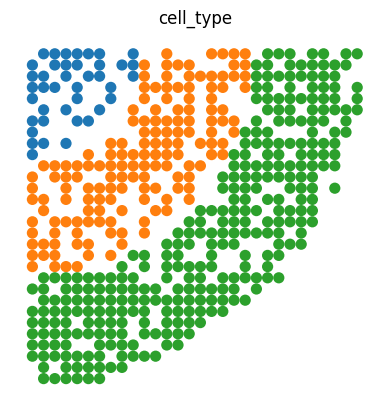

In [13]:
sc.pl.spatial(adata_rna, img_key=None, color=['cell_type'], 
                      legend_loc=None, legend_fontsize=12, show=False, frameon=False,
                      spot_size=1)

# plot the communication stength

In [14]:
from RegChat import utils

In [15]:
x = utils.neg_log10_transform(LRFG_strength_pd.to_numpy(), replace_zero=1e-12)

In [16]:
var_lr = pd.DataFrame({
    'gene_name': LRFG_strength_pd.columns
}, index=LRFG_strength_pd.columns)
adata_rna_lr = ad.AnnData(X=x, obs=obs, var=var_lr)
adata_rna_lr

AnnData object with n_obs × n_vars = 490 × 31
    obs: 'cell_type'
    var: 'gene_name'

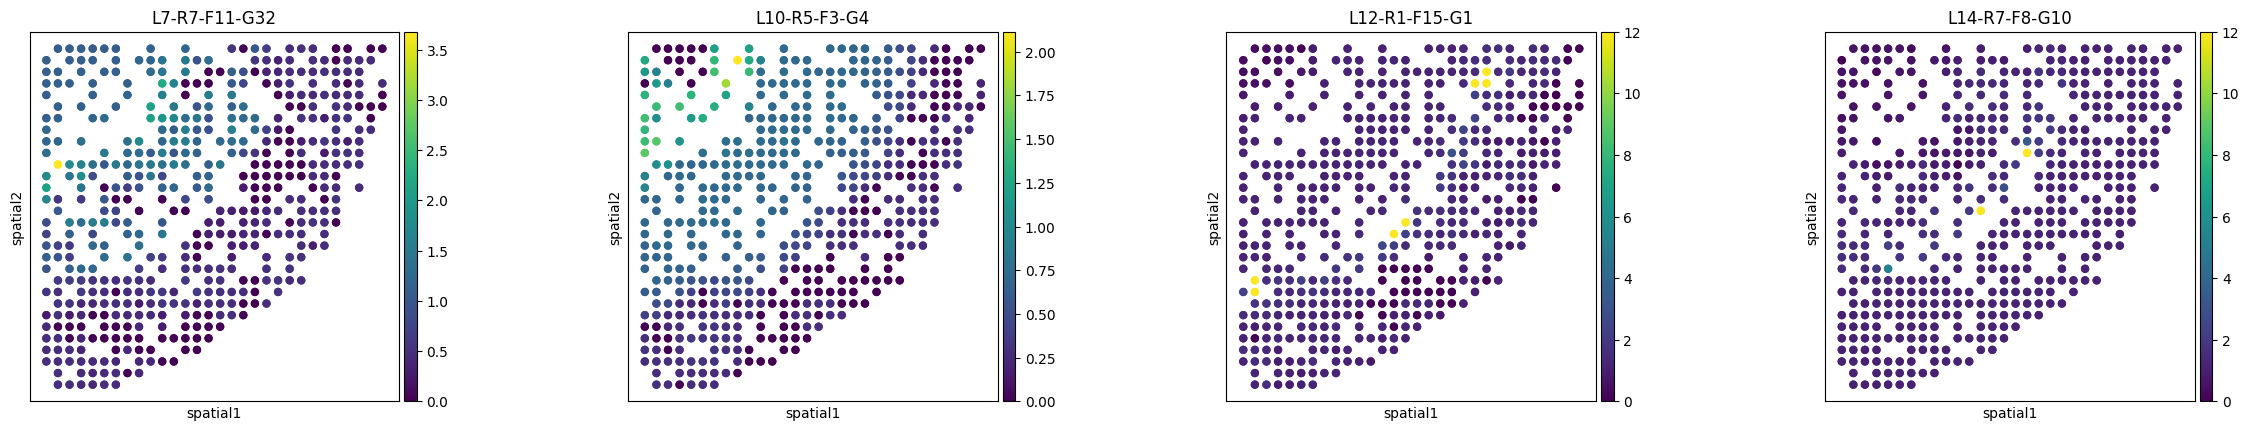

In [17]:
adata_rna_lr.obsm = adata_rna.obsm
sq.pl.spatial_scatter(
    adata_rna_lr,
    shape=None,
    color=['L7-R7-F11-G32',"L10-R5-F3-G4","L12-R1-F15-G1","L14-R7-F8-G10"],
    size=100
)

# plot the direction only for the significant spots for focused metapath

In [18]:
from RegChat import analysis

In [19]:
p_val_cutoff = 0.05

In [20]:
res_df = analysis.get_signifcant_node(adata_rna,result_LR, nei_adj,coord,p_val_cutoff,type = 'mix',topk = 2)

In [21]:
color_map = {
    'CT1': '#1f77b4',       # 蓝色
    'CT2': '#ff7f0e',  # 橙色
    'CT3': '#2ca02c'  # 绿色
}
coord_df = coord.copy()
coord_df['color'] = cell_type['Label'].map(color_map)

In [22]:
pathway_name_l = ['L7-R7',"L10-R5","L12-R1","L14-R7"]
meta_path_l = ['L7-R7-F11-G32',"L10-R5-F3-G4","L12-R1-F15-G1","L14-R7-F8-G10"]

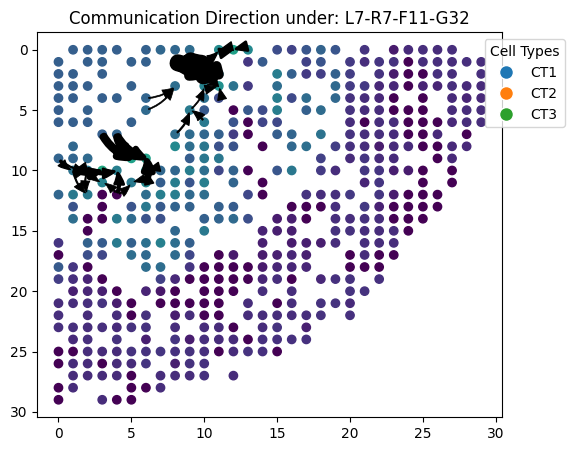

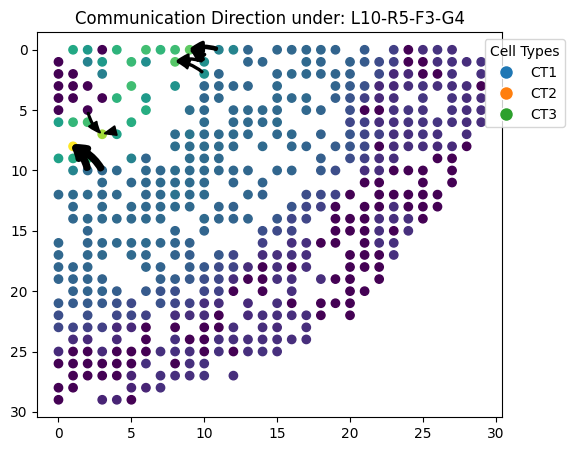

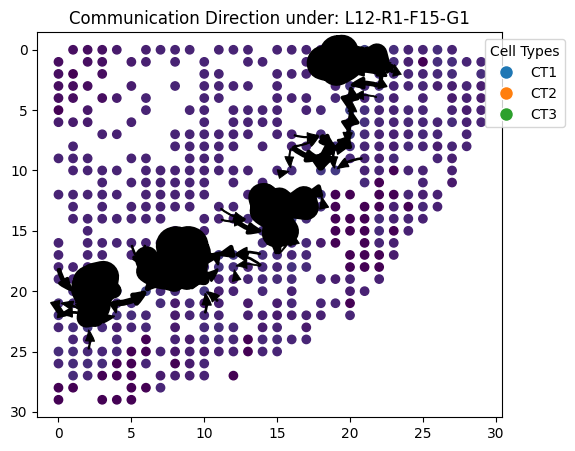

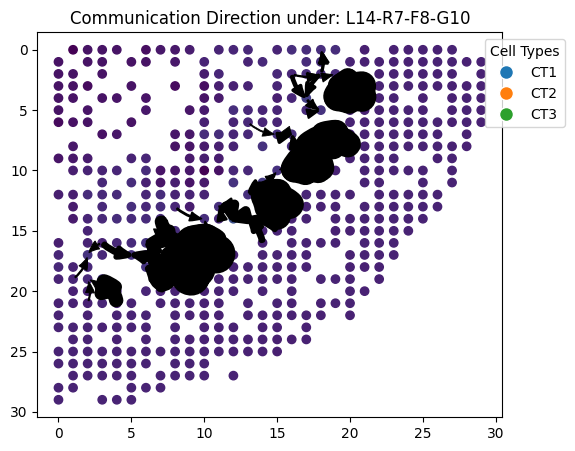

In [23]:
# use the continous plot
for i in range(len(meta_path_l)):
    colors = utils.neg_log10_transform(LRFG_strength_pd[meta_path_l[i]].to_numpy(), replace_zero=1e-12)
    res_specific_df = res_df[res_df['LR_Name'].str.contains(pathway_name_l[i])]
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=colors, cmap='viridis') 
    plt.gca().invert_yaxis() 
    for index, row in res_specific_df.iterrows():
        strength = row['Comm_Score']
        lw = max(0.5, strength * 1e1)
        arrowstyle = ArrowStyle("Simple", head_length=1, head_width=0.8, tail_width=0.1)
        arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=8)
        plt.gca().add_patch(arrow)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
    plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')

    plt.title('Communication Direction under: '+ meta_path_l[i])
    #plt.savefig(figpath + 'Sig_one_arrow_' + pathway_name + '_2.png', dpi=300, bbox_inches='tight') 
    #plt.savefig(figpath + 'Sig_two_arrow_' + meta_path_l[i] + '_significance_0.05_80.pdf', bbox_inches='tight')
    plt.show()

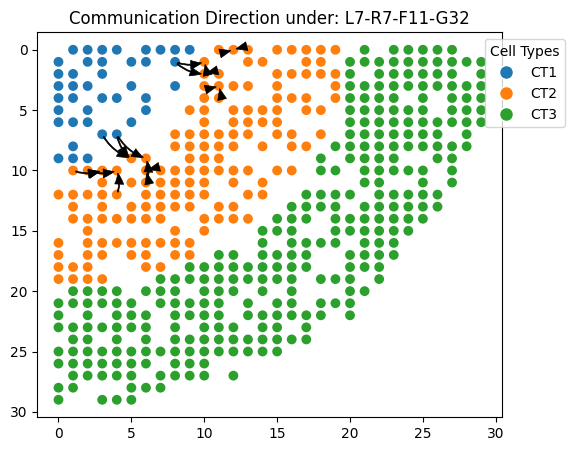

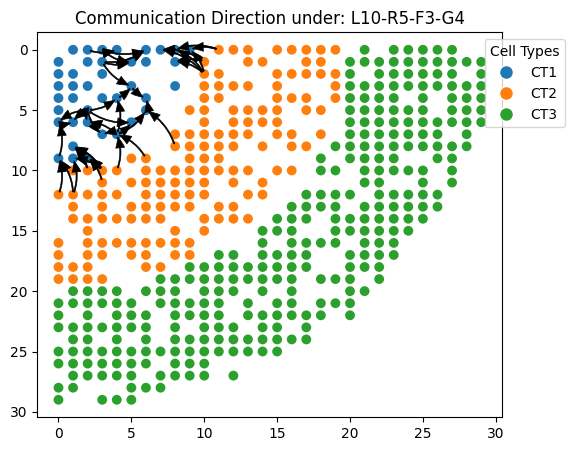

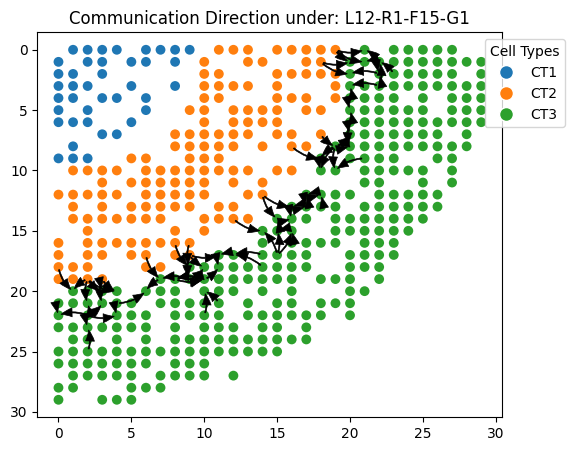

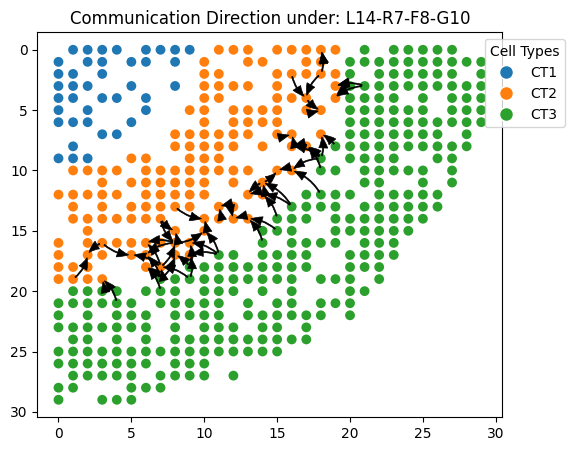

In [25]:
for i in range(len(meta_path_l)):
    res_specific_df = res_df[res_df['LR_Name'].str.contains(pathway_name_l[i])]
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'], alpha=1, s=50, linewidths=0) 
    plt.gca().invert_yaxis() 
    for index, row in res_specific_df.iterrows():
        strength = row['Comm_Score']
        lw = max(0.5, strength * 1e1)
        arrowstyle = ArrowStyle("Simple", head_length=1, head_width=0.8, tail_width=0.1)
        arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=8)
        plt.gca().add_patch(arrow)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
    plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')

    plt.title('Communication Direction under: '+ meta_path_l[i])
    #plt.savefig(figpath + 'Sig_one_arrow_' + pathway_name + '_2.png', dpi=300, bbox_inches='tight') 
    #plt.savefig(figpath + 'Sig_two_arrow_' + meta_path_l[i] + '_significance_0.05_80.pdf', bbox_inches='tight')
    plt.show()